**EPILEPTIC SEIZURE RECOGNITION**

**Data Manipulation**

In [1]:
import pandas as pd 

import tensorflow as tf

print(tf.__version__)

2.4.0


In [2]:
raw = pd.read_csv("Epileptic_Seizure_Recognition.csv")
raw = raw.drop("Unnamed",axis=1)
raw.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [3]:
y = raw["y"]
e = []
for x in range(0,len(raw)):
    if y[x] in [2,3,4,5]: 
        e.append(0)
    else:
        e.append(1)

In [4]:
raw.append(e)

raw.insert(179,"e",e,True)
raw.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X171,X172,X173,X174,X175,X176,X177,X178,y,e
0,135,190,229,223,192,125,55,-9,-33,-38,...,-15,-31,-77,-103,-127,-116,-83,-51,4,0
1,386,382,356,331,320,315,307,272,244,232,...,150,146,152,157,156,154,143,129,1,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,64,48,19,-12,-30,-35,-35,-36,5,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-81,-80,-77,-85,-77,-72,-69,-65,5,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,2,-12,-32,-41,-65,-83,-89,-73,5,0


**Principal Component Analysis for Data Visualization**

In [5]:
from sklearn.preprocessing import StandardScaler

features = raw.columns[0:178]
X = raw.loc[:, features].values
y = raw.loc[:,"y"]
e = raw.loc[:,"e"]

X = StandardScaler().fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, e_train, e_test = train_test_split(X, e, test_size = 0.25, random_state = 21, stratify = e)

In [7]:
from sklearn.decomposition import PCA 
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook,reset_output,save,show

output_notebook()
def pca_visualization(X,y):
    pca = PCA(n_components = 2)
    pc = pca.fit_transform(X)
    pcDF = pd.DataFrame(data = pc, columns = ['pc1','pc2'])
    pcDF['e'] = y.values
    epilepsy = pcDF.loc[pcDF['e']==1,]
    not_epilepsy = pcDF.loc[pcDF['e']==0,]
    reset_output()
    output_notebook()
    p = figure()
    p.scatter(x = epilepsy['pc1'], 
              y = epilepsy['pc2'], 
              marker="x", 
              fill_alpha=0.5, 
              size=6, 
              legend = "Epilepsy")
    p.scatter(x = not_epilepsy['pc1'], 
              y = not_epilepsy['pc2'], 
              marker="triangle", 
              fill_alpha=0.3, 
              size=6, 
              fill_color="orange",
              line_color="orange",
              legend = "Not Epilepsy")
    p.xaxis.axis_label = "Principal Component 1"
    p.yaxis.axis_label = "Principal Component 2"
    show(p)

Loading BokehJS ...

In [8]:
pca_visualization(X_train,e_train)

Loading BokehJS ...

In [9]:
import numpy as np
rate = np.mean(e_train)
length = len(e_train)

print("There are {}".format(length), "examples in the training set and only {}".format(round(length*rate)), "of them are labeled as Epilepsy.")

There are 8625 examples in the training set and only 1725 of them are labeled as Epilepsy.


**Over-Sampling with SMOTE**

In [10]:
from imblearn.over_sampling import am

oversampling = SMOTE()
X_train_b, e_train_b = oversampling.fit_resample(X_train,e_train)

In [11]:
from collections import Counter

counter_imb = Counter(e_train)
counter_b = Counter(e_train_b)

print(counter_imb)
print(counter_b)

Counter({0: 6900, 1: 1725})
Counter({1: 6900, 0: 6900})


In [12]:
pca_visualization(X_train_b,e_train_b)

Loading BokehJS ...

In [13]:
rate = np.mean(e_train_b)
length = len(e_train_b)

print("There are {}".format(length), "examples in the training set after SMOTE and now {}".format(round(length*rate)), "of them are labeled as Epilepsy.")

There are 13800 examples in the training set after SMOTE and now 6900 of them are labeled as Epilepsy.


**Principal Component Analysis for Speeding Up the Machine Learning Algorithm**

In [14]:
pca = PCA(n_components = 40)
pca.fit(X_train_b)

PCA(n_components=40)

In [15]:
X_train_reduced_pca = pca.transform(X_train_b)
X_test_reduced_pca = pca.transform(X_test)

**Feature Importance with Extra Tree Classifier**

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

feature_imp = []

for x in range(1,500):
    model = ExtraTreesClassifier()
    model.fit(X_train_b,e_train_b)
    feature_imp =+ model.feature_importances_

In [17]:
from operator import itemgetter
from heapq import nlargest, nsmallest

largest40 = nlargest(40, enumerate(feature_imp), itemgetter(1))

In [18]:
largest40_col_name = []
largest40_values = []
largest40_index = []

for index, value in largest40: 
    name = 's'+ str(index+1)
    largest40_col_name.append(name)
    largest40_values.append(value)
    largest40_index.append(index)

In [19]:
output_notebook()

p = figure(y_range = largest40_col_name, title = "Most Important 40 Features", x_axis_label = "Importance", tools = "")
p.hbar(y = largest40_col_name, right = largest40_values, left = 0, height = 0.5, color = 'orange', fill_alpha = 0.5)
show(p)

Loading BokehJS ...

In [20]:
X_train_f_reduced = X_train_b[:,largest40_index]
X_test_f_reduced = X_test[:,largest40_index]

**Sequential Forward Feature Selection**

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.neighbors import KNeighborsClassifier

mdl = KNeighborsClassifier(n_neighbors = 1)

sequential_forward = sfs(mdl,
                         k_features=40,
                         forward=True,
                         floating=False,
                         verbose=2,
                         scoring='accuracy',
                         cv=10)

In [22]:
sequential_forward_forward = sequential_forward.fit(X_train_b, e_train_b)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed:   57.9s finished

[2021-01-04 09:25:31] Features: 1/40 -- score: 0.8686956521739131[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:  1.0min finished

[2021-01-04 09:26:31] Features: 2/40 -- score: 0.784927536231884[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  1.1min finished

[2021-01-04 09:27:38] Features: 3/40 -- score: 0.8439855072463768[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [23]:
feat_cols = list(sequential_forward_forward.k_feature_idx_)
print(feat_cols)

[0, 1, 7, 14, 15, 17, 21, 25, 27, 30, 36, 37, 39, 43, 48, 51, 58, 59, 63, 68, 76, 83, 85, 87, 90, 94, 99, 104, 105, 111, 112, 113, 126, 127, 133, 144, 145, 147, 151, 169]


In [24]:
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10,10)

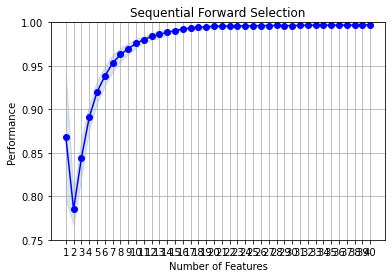

In [25]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sequential_forward.get_metric_dict(), kind='std_dev')

plt.pyplot.ylim([0.75, 1])
plt.pyplot.title('Sequential Forward Selection')
plt.pyplot.grid()
plt.pyplot.show()

In [26]:
X_train_sf_reduced = X_train_b[:,feat_cols]
X_test_sf_reduced = X_test[:,feat_cols]

**K-Nearest Neighbors after Feature Extraction with Principal Component Analysis**

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def model_comparison(X_train, y_train, X_test, y_test, model, parameters, cv, scoring):
    model_cv = GridSearchCV(model, parameters, cv = cv, scoring = scoring)
    model_cv.fit(X_train,y_train)
    prediction = model_cv.predict(X_test)
    prediction_prob = model_cv.predict_proba(X_test)[:,1]
    print("Classification report:\n\n",classification_report(prediction,y_test))
    plot_confusion_matrix(model_cv, X_test, y_test,
                          display_labels = ['Not Epilepsy','Epilepsy'],
                          cmap = plt.cm.Blues, 
                          values_format = ".2f")
    return prediction, prediction_prob, model_cv

Classification report:

               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2382
           1       0.84      0.98      0.91       493

    accuracy                           0.97      2875
   macro avg       0.92      0.97      0.94      2875
weighted avg       0.97      0.97      0.97      2875



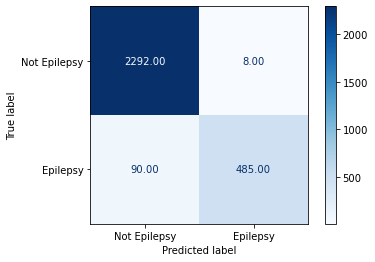

In [28]:
from sklearn.neighbors import KNeighborsClassifier
param_knn = {'n_neighbors':np.arange(1,5)}

knn_prediction_pca, knn_prediction_prob_pca, knn_pca = model_comparison(X_train = X_train_reduced_pca,
                                                                        y_train = e_train_b, 
                                                                        X_test = X_test_reduced_pca,
                                                                        y_test = e_test, 
                                                                        model = KNeighborsClassifier(),
                                                                        parameters = param_knn,
                                                                        cv=10, scoring= 'f1')

**K-Nearest Neighbors after Feature Selection with Extra Trees Classifier**

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.96      0.98      2365
           1       0.85      0.96      0.90       510

    accuracy                           0.96      2875
   macro avg       0.92      0.96      0.94      2875
weighted avg       0.97      0.96      0.96      2875



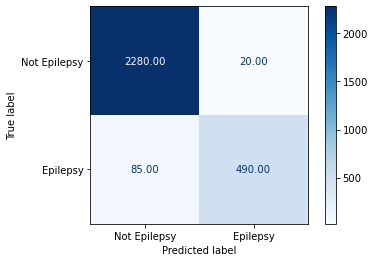

In [29]:
knn_prediction_f, knn_prediction_prob_f, knn_f = model_comparison(X_train = X_train_f_reduced,
                                                                  y_train = e_train_b, 
                                                                  X_test = X_test_f_reduced,
                                                                  y_test = e_test, 
                                                                  model = KNeighborsClassifier(),
                                                                  parameters = param_knn,
                                                                  cv=10, scoring= 'f1')

**K-Nearest Neighbors after Feature Selection with Sequential Forward Feature Selection**

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2361
           1       0.86      0.96      0.91       514

    accuracy                           0.97      2875
   macro avg       0.93      0.96      0.94      2875
weighted avg       0.97      0.97      0.97      2875



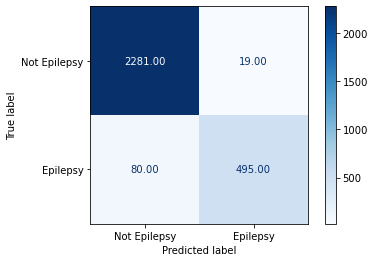

In [30]:
param_knn = {'n_neighbors':np.arange(1,5)}
knn_prediction_sf, knn_prediction_prob_sf, knn_sf = model_comparison(X_train = X_train_sf_reduced,
                                                                     y_train = e_train_b, 
                                                                     X_test = X_test_sf_reduced,
                                                                     y_test = e_test, 
                                                                     model = KNeighborsClassifier(),
                                                                     parameters = param_knn,
                                                                     cv=10, scoring= 'f1')

**Decision Tree**

Classification report:

               precision    recall  f1-score   support

           0       0.93      0.99      0.96      2159
           1       0.95      0.76      0.85       716

    accuracy                           0.93      2875
   macro avg       0.94      0.88      0.90      2875
weighted avg       0.93      0.93      0.93      2875



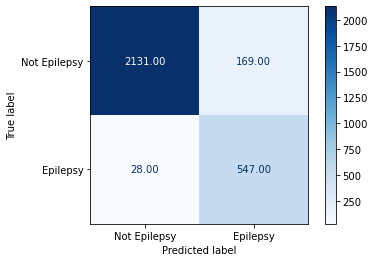

In [31]:
from sklearn.tree import DecisionTreeClassifier

param_dtc = {'max_depth':         [200,250,300,1000],
             'max_features':      [25,30,35],
             'min_samples_split': [5,10,20,30,40,50],
             'min_samples_leaf':  [25,50,150,250,500,1000]}

dtc_prediction_pca, dtc_prediction_prob_pca, dtc_pca = model_comparison(X_train = X_train_reduced_pca,
                                                                        y_train = e_train_b, 
                                                                        X_test  = X_test_reduced_pca,
                                                                        y_test  = e_test, 
                                                                        model   = DecisionTreeClassifier(),
                                                                        parameters = param_dtc,
                                                                        cv = 10, 
                                                                        scoring = 'f1')

**Random Forest**

Classification report:

               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2213
           1       0.99      0.86      0.92       662

    accuracy                           0.97      2875
   macro avg       0.98      0.93      0.95      2875
weighted avg       0.97      0.97      0.97      2875



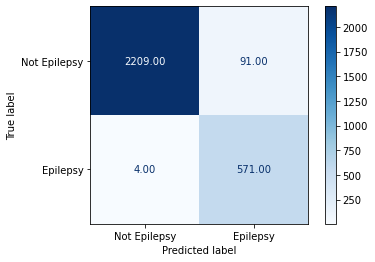

In [32]:
from sklearn.ensemble import RandomForestClassifier

param_rf = {'n_estimators': [300,500,700],
            'max_features': [3,5,7],
            'max_depth':    [80,100,120]}

rf_prediction_pca, rf_prediction_prob_pca, rf_pca = model_comparison(X_train = X_train_reduced_pca,
                                                                     y_train = e_train_b, 
                                                                     X_test = X_test_reduced_pca,
                                                                     y_test = e_test, 
                                                                     model = RandomForestClassifier(),
                                                                     parameters = param_rf,
                                                                     cv=10, scoring = 'precision')

**Neural Network**

In [33]:
#from keras.models import Sequential
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras import layers
from keras.layers import Dense
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import KFold
from keras.layers import Activation
from keras.optimizers import Adam

print(tf.__version__)
X_reduced_pca = np.concatenate((X_train_reduced_pca,X_test_reduced_pca))
e_reduced_pca = np.concatenate((e_train_b, e_test))

kf_cv = KFold(10, shuffle=True, random_state = 42)

oos_y = []
oos_pred = []
fold = 0

def tuning_parameters(learning_rate, epochs):
    for train, test in kf_cv.split(X_reduced_pca):       
        x_train = X_reduced_pca[train]
        y_train = e_reduced_pca[train]
        x_test = X_reduced_pca[test]
        y_test = e_reduced_pca[test]
    
        nn = Sequential()
        nn.add(layers.Dense(100, input_dim = 40, activation = 'relu'))
        nn.add(layers.Dense(100, activation = 'relu'))
        nn.add(layers.Dense(1, activation = 'sigmoid'))
        opt = Adam(lr = learning_rate)
        nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=tf.keras.metrics.RecallAtPrecision(precision=0.9))
    
        nn.fit(x_train,y_train,validation_data=(x_test,y_test), epochs = epochs, verbose = 0)
    
        y_pred = nn.predict_classes(x_test)
    
        oos_y.append(y_test)
        oos_y_concat = np.concatenate(oos_y)
    
        oos_pred.append(y_pred)    
        oos_pred_concat = np.concatenate(oos_pred)
    
    f1_score = metrics.f1_score(oos_pred_concat,oos_y_concat)
    rec = metrics.recall_score(oos_pred_concat,oos_y_concat)
    prec = metrics.precision_score(oos_pred_concat,oos_y_concat)
    return f1_score, rec, prec

Using TensorFlow backend.


2.4.0


In [34]:
learning_rates = [0.0001,0.001, 0.01, 0.1, 1]

f1 = []
rec = []
prec = []

for i in range(len(learning_rates)): 
    x,y,z = tuning_parameters(learning_rate = learning_rates[i], epochs = 100)
    f1.append(x)
    rec.append(y)
    prec.append(z)

C:\Users\vnrvjiet\anaconda3\envs\gpu-test1\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\vnrvjiet\anaconda3\envs\gpu-test1\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model d

In [35]:
import tensorflow
nn_pca = tensorflow.keras.Sequential()
nn_pca.add(layers.Dense(1200, input_dim = 40, activation = 'relu'))
nn_pca.add(layers.Dense(1200, activation = 'relu'))
nn_pca.add(layers.Dense(1200, activation = 'relu'))
nn_pca.add(layers.Dense(1, activation = 'sigmoid'))
#opt = Adam(lr = 0.001)
nn_pca.compile(loss='binary_crossentropy', optimizer='adam', metrics=tf.keras.metrics.Recall())
nn_pca.fit(X_train_reduced_pca,e_train_b,validation_data=(X_test_reduced_pca,e_test), epochs = 30, verbose = 0)

C:\Users\vnrvjiet\anaconda3\envs\gpu-test1\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


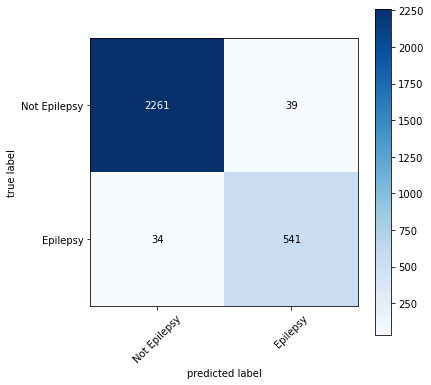

In [36]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix as plot_cm

nn_prediction_prob_pca = nn_pca.predict(X_test_reduced_pca)
nn_prediction_prob_pca_cm = (nn_prediction_prob_pca > 0.5)

nn_prediction_pca = nn_pca.predict_classes(X_test_reduced_pca)

cm = confusion_matrix(e_test, nn_prediction_prob_pca_cm)

class_names = ['Not Epilepsy', 'Epilepsy']

fig,ax  = plot_cm(conf_mat=cm,
                  colorbar=True,
                  class_names = class_names,
                  figsize = (6,6))

**Model Selection**

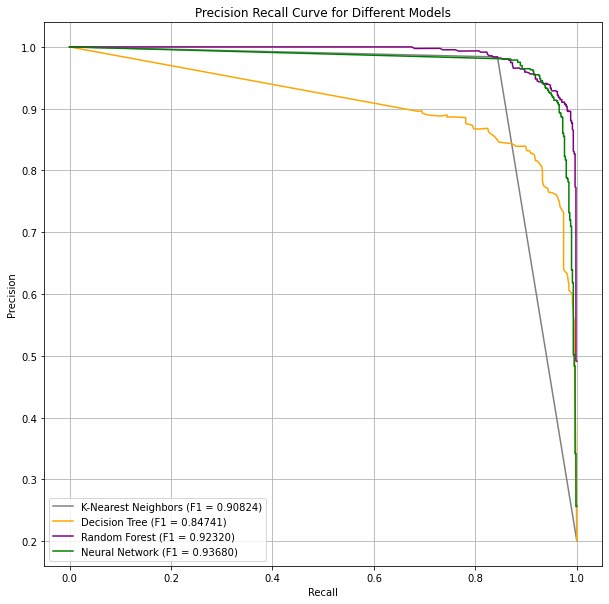

In [37]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, f1_score
import matplotlib.pyplot as plt

precision_knn, recall_knn, _ = precision_recall_curve(e_test,knn_prediction_prob_pca)
precision_dtc, recall_dtc, _ = precision_recall_curve(e_test,dtc_prediction_prob_pca)
precision_rf, recall_rf, _ = precision_recall_curve(e_test,rf_prediction_prob_pca)
precision_nn, recall_nn, _ = precision_recall_curve(e_test,nn_prediction_prob_pca)

f1_knn = f1_score(e_test, knn_prediction_pca)
f1_dtc = f1_score(e_test, dtc_prediction_pca)
f1_rf = f1_score(e_test, rf_prediction_pca)
f1_nn = f1_score(e_test, nn_prediction_pca)

fig = plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(recall_knn, precision_knn, label = "K-Nearest Neighbors (F1 = {:.5f})".format(f1_knn), c = 'gray')
ax.plot(recall_dtc, precision_dtc, label = "Decision Tree (F1 = {:.5f})".format(f1_dtc), c = 'orange')
ax.plot(recall_rf, precision_rf, label = "Random Forest (F1 = {:.5f})".format(f1_rf), c = 'purple')
ax.plot(recall_nn, precision_nn, label = "Neural Network (F1 = {:.5f})".format(f1_nn), c = 'green')

ax.grid()
ax.legend()
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision Recall Curve for Different Models")
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
def specificity_score(e_act, e_pred, threshold): 
    return sum((e_pred < threshold) & (e_act == 0))/sum(e_act == 0)

def report(e_act, e_pred, threshold): 
    precision = precision_score(e_act, (e_pred>threshold))
    recall = recall_score(e_test, (e_pred>threshold))
    specificity = specificity_score(e_act, e_pred, threshold)
    accuracy = accuracy_score(e_act, (e_pred>threshold))
    print('Precision:%.5f'%precision)   
    print('Recall:%.5f'%recall)
    print('Specificity:%.5f'%specificity)
    print('Accuracy:%.5f'%accuracy)
    return precision, recall, specificity, accuracy

In [39]:
print("The performance of the models on the test set are summarised in the table below:\n")    
print("\033[1m" + "K-Nearest Neighbors"+ '\033[0m')
precision_knn, recall_knn, specificity_knn, accuracy_knn = report(e_test, knn_prediction_prob_pca, threshold = 0.5)   
print("\n")
print("\033[1m" + "Decision Tree"+ '\033[0m')
precision_dtc, recall_dtc, specificity_dtc, accuracy_dtc = report(e_test, dtc_prediction_prob_pca, threshold = 0.5)   
print("\n")
print("\033[1m" + "Random Forest"+ '\033[0m')
precision_rf, recall_rf, specificity_rf, accuracy_rf = report(e_test, rf_prediction_prob_pca, threshold = 0.5)   
print("\n")
print("\033[1m" + "Neural Network"+ '\033[0m')
precision_nn, recall_nn, specificity_nn, accuracy_nn = report(e_test, nn_prediction_prob_pca.flatten(), threshold = 0.5)   

The performance of the models on the test set are summarised in the table below:

K-Nearest Neighbors
Precision:0.98377
Recall:0.84348
Specificity:0.99652
Accuracy:0.96591


Decision Tree
Precision:0.76397
Recall:0.95130
Specificity:0.92435
Accuracy:0.93148


Random Forest
Precision:0.86254
Recall:0.99304
Specificity:0.95913
Accuracy:0.96696


Neural Network
Precision:0.93276
Recall:0.94087
Specificity:0.98304
Accuracy:0.97461


In [40]:
performance = tuple([precision_knn,precision_dtc,precision_rf,precision_nn,
                     recall_knn,recall_dtc,recall_rf,recall_nn,
                     specificity_knn ,specificity_dtc ,specificity_rf,specificity_nn,
                     accuracy_knn , accuracy_dtc , accuracy_rf, accuracy_nn])

metrics = np.concatenate([["Precision"],
                          ["Recall"],
                          ["Specificity"],
                          ["Accuracy"]])

models = ["K-Nearest Neighbors", "Decision Tree","Random Forest", "Neural Network"]

stacked = [(metric,model) for metric in metrics for model in models]

In [41]:
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Viridis3
from bokeh.models import LabelSet
from bokeh.transform import factor_cmap

reset_output()
output_notebook()

x = stacked
y = np.round(np.array(performance)*100,2)

source = ColumnDataSource(data=dict(x=x, y=y))

p = figure(x_range=FactorRange(*x), 
           plot_height=400, 
           plot_width = 1200, 
           title="Model Comparison from Different Perspectives",
           toolbar_location=None, 
           tools="")

p.vbar(x='x', 
       top='y', 
       width=0.9, 
       source=source,
       fill_color = factor_cmap('x', 
                                 palette = Viridis3, 
                                 factors = models, 
                                 start = 1, 
                                 end = 3))

labels = LabelSet(x='x', 
                  y='y', 
                  text='y', 
                  level='glyph',
                  x_offset=-13, 
                  y_offset=0, 
                  source=source, 
                  text_font_size="11px",
                  render_mode='canvas')

p.add_layout(labels)
p.title.text_font_size = "12px"
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.yaxis.axis_label = 'Performance(%)'
p.xaxis.major_label_orientation = 1
show(p)

Loading BokehJS ...

C:\Users\vnrvjiet\anaconda3\envs\gpu-test1\lib\site-packages\bokeh\models\mappers.py:150: UserWarning: Palette length does not match number of factors. ['Neural Network'] will be assigned to `nan_color` gray
  warnings.warn("Palette length does not match number of factors. %s will be assigned to `nan_color` %s" % (extra_factors, self.nan_color))


**Analysis of Incorrect Predictions**

In [42]:
incorrect_ind = rf_pca.predict(X_test_reduced_pca)!=e_test
correct_ind = rf_pca.predict(X_test_reduced_pca)==e_test

In [43]:
incorrect_df = pd.DataFrame(X_test[incorrect_ind])
incorrect_df["e"] = e_test.values[incorrect_ind]

In [44]:
correct_df = pd.DataFrame(X_test[correct_ind])
correct_df["e"] = e_test.values[correct_ind]

In [45]:
fp = incorrect_df[incorrect_df["e"]==0]
fn = incorrect_df[incorrect_df["e"]==1]

In [46]:
tn = correct_df[correct_df["e"]==0]
tp = correct_df[correct_df["e"]==1]

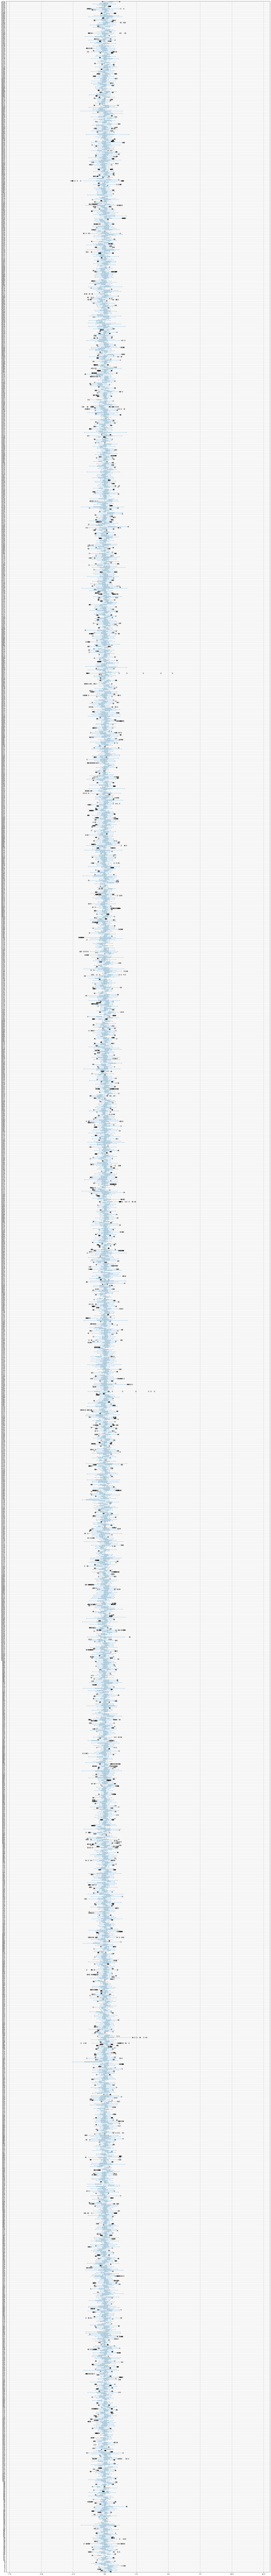

In [47]:
tn.T.boxplot(figsize = (30,300),vert=False)
plt.xlim(-7.75,13)
plt.show()

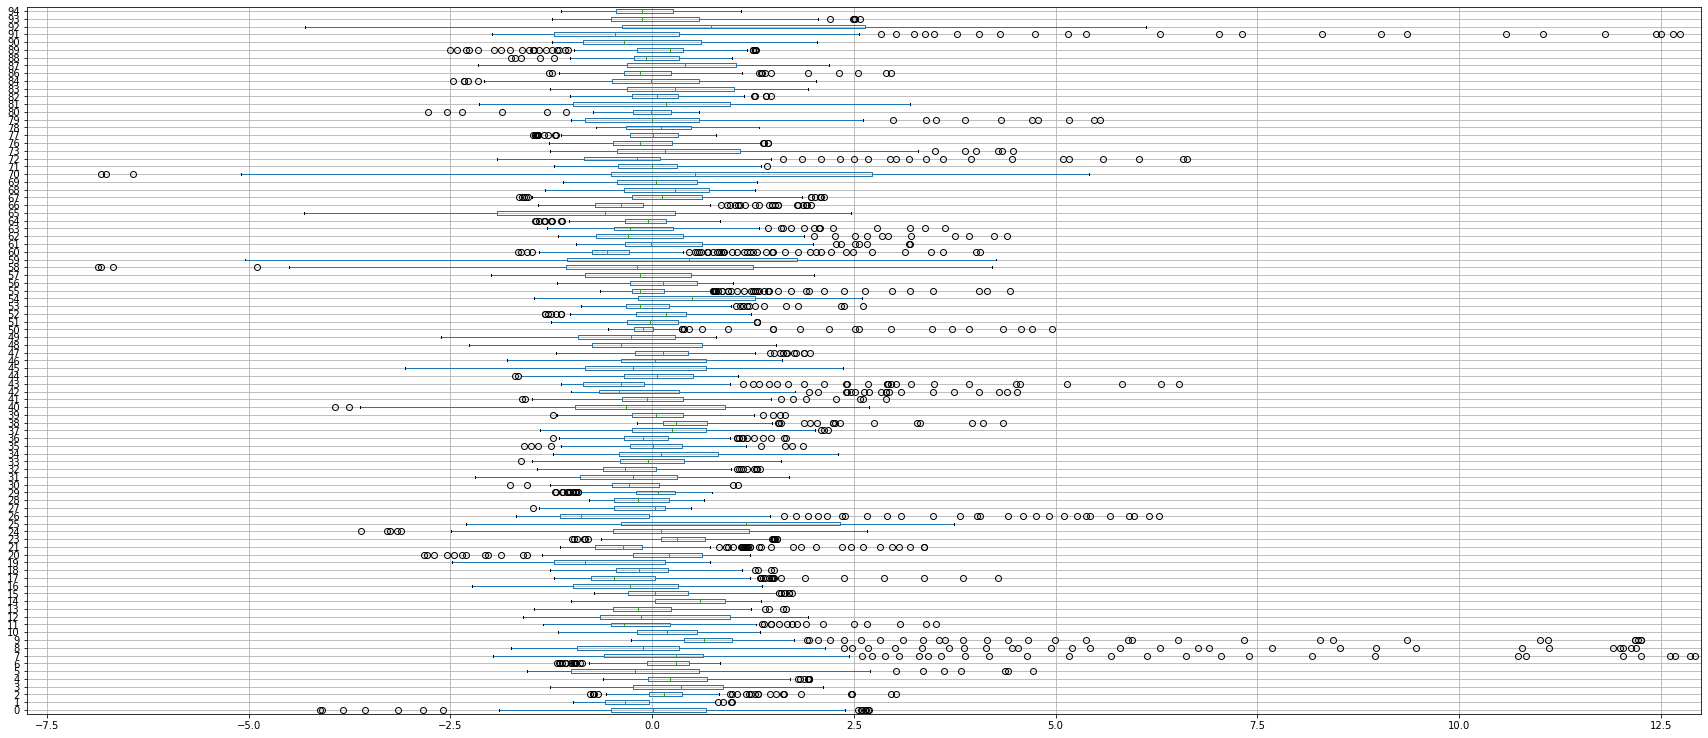

In [48]:
fp.T.boxplot(figsize = (30,13),vert=False)
plt.xlim(-7.75,13)
plt.show()

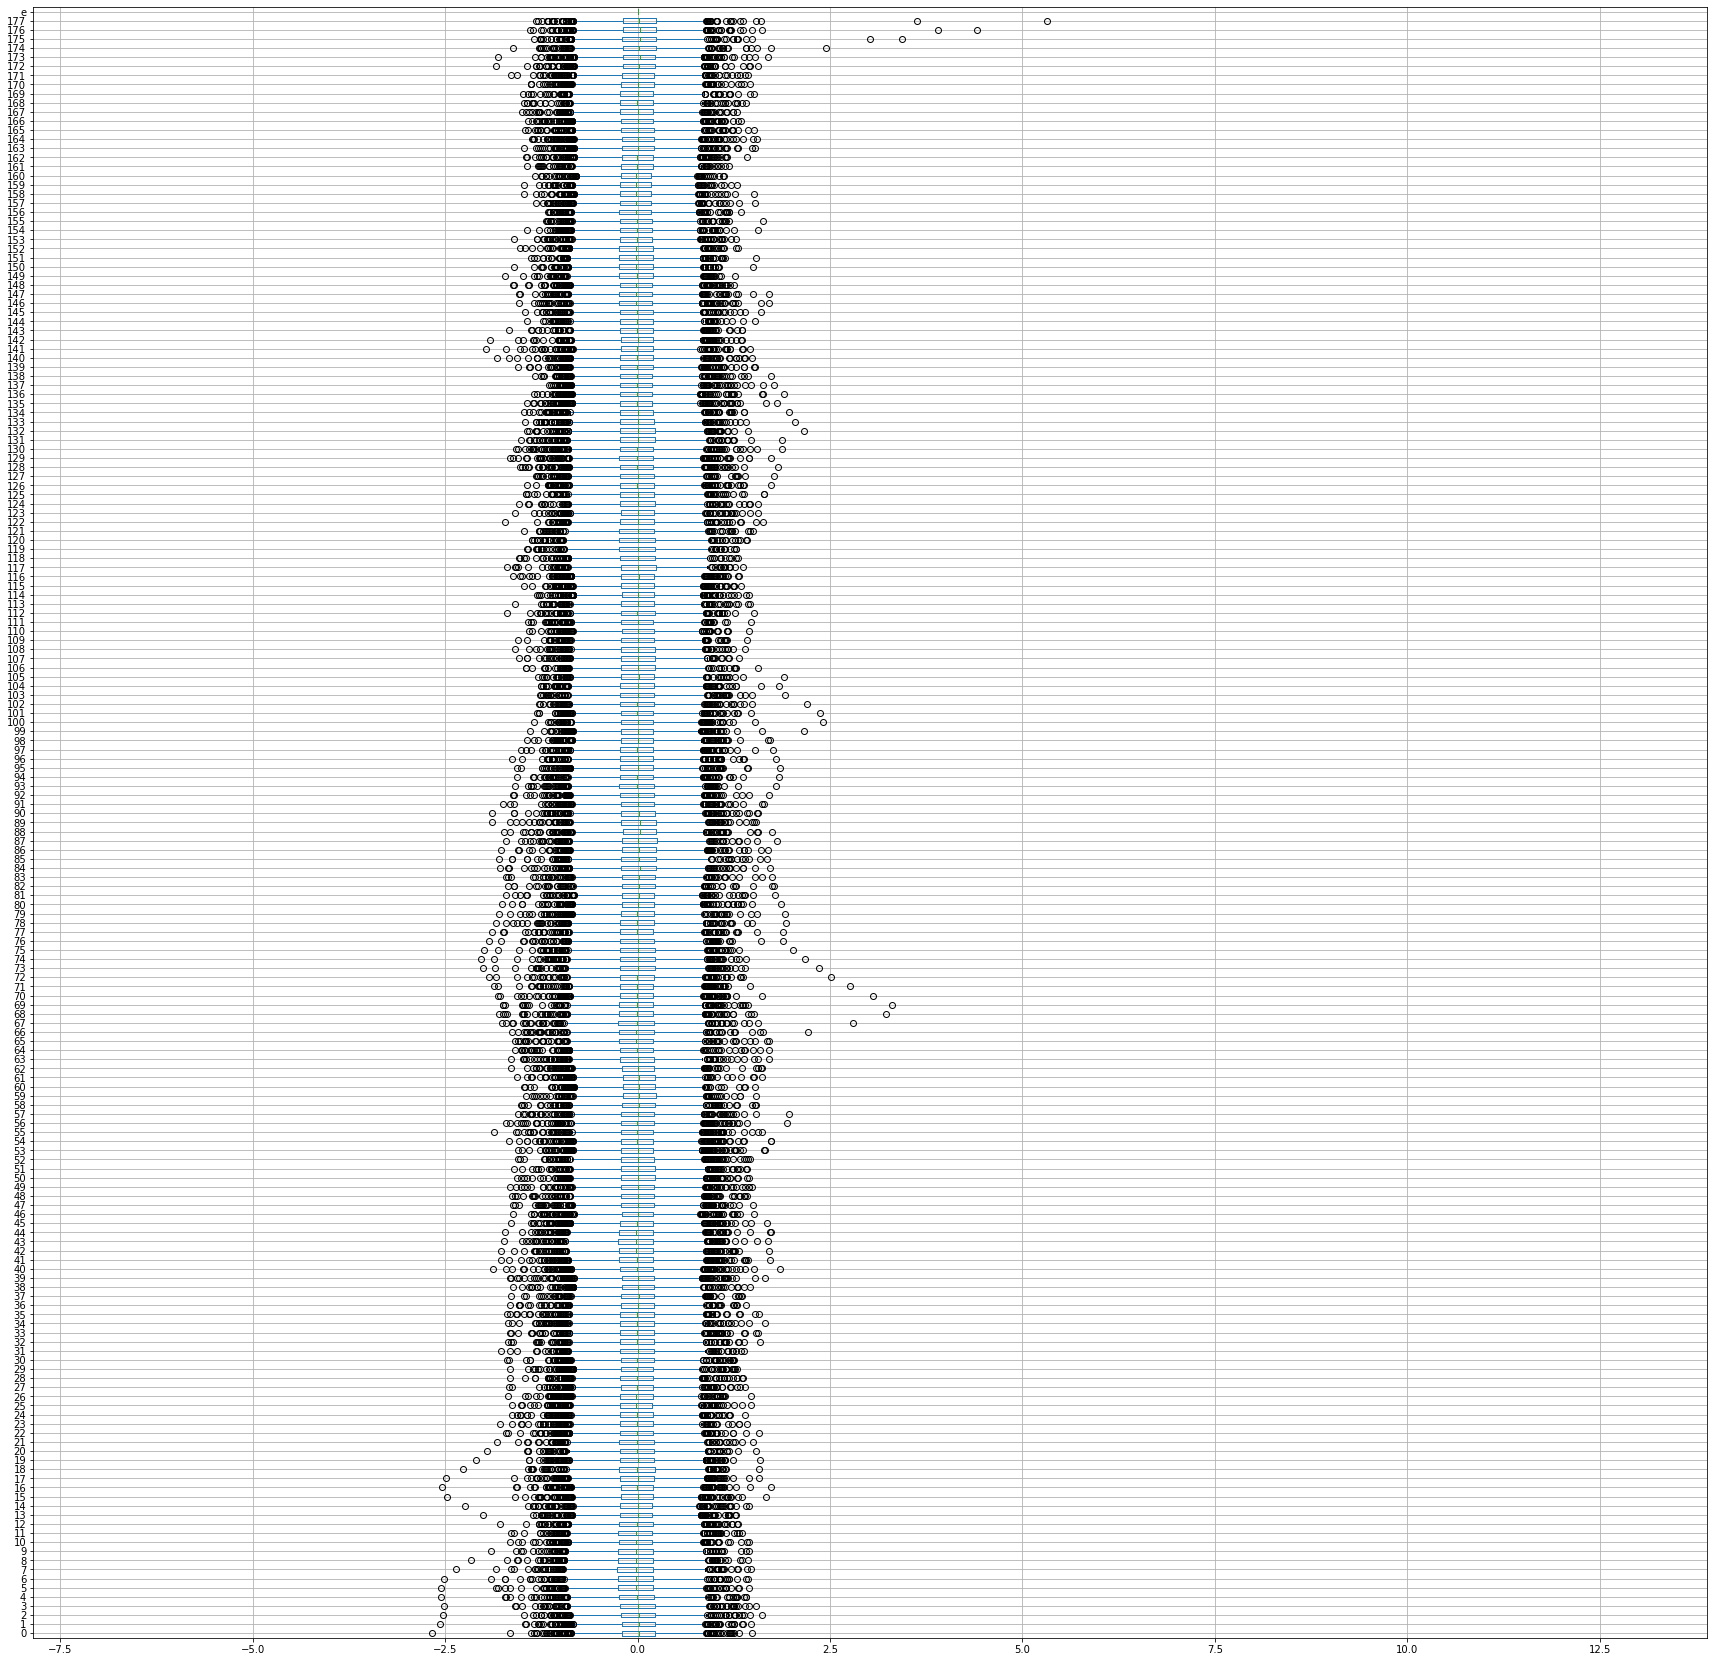

In [49]:
tn.boxplot(figsize = (30,30),vert=False)
plt.xlim(-7.85,13.90)
plt.show()

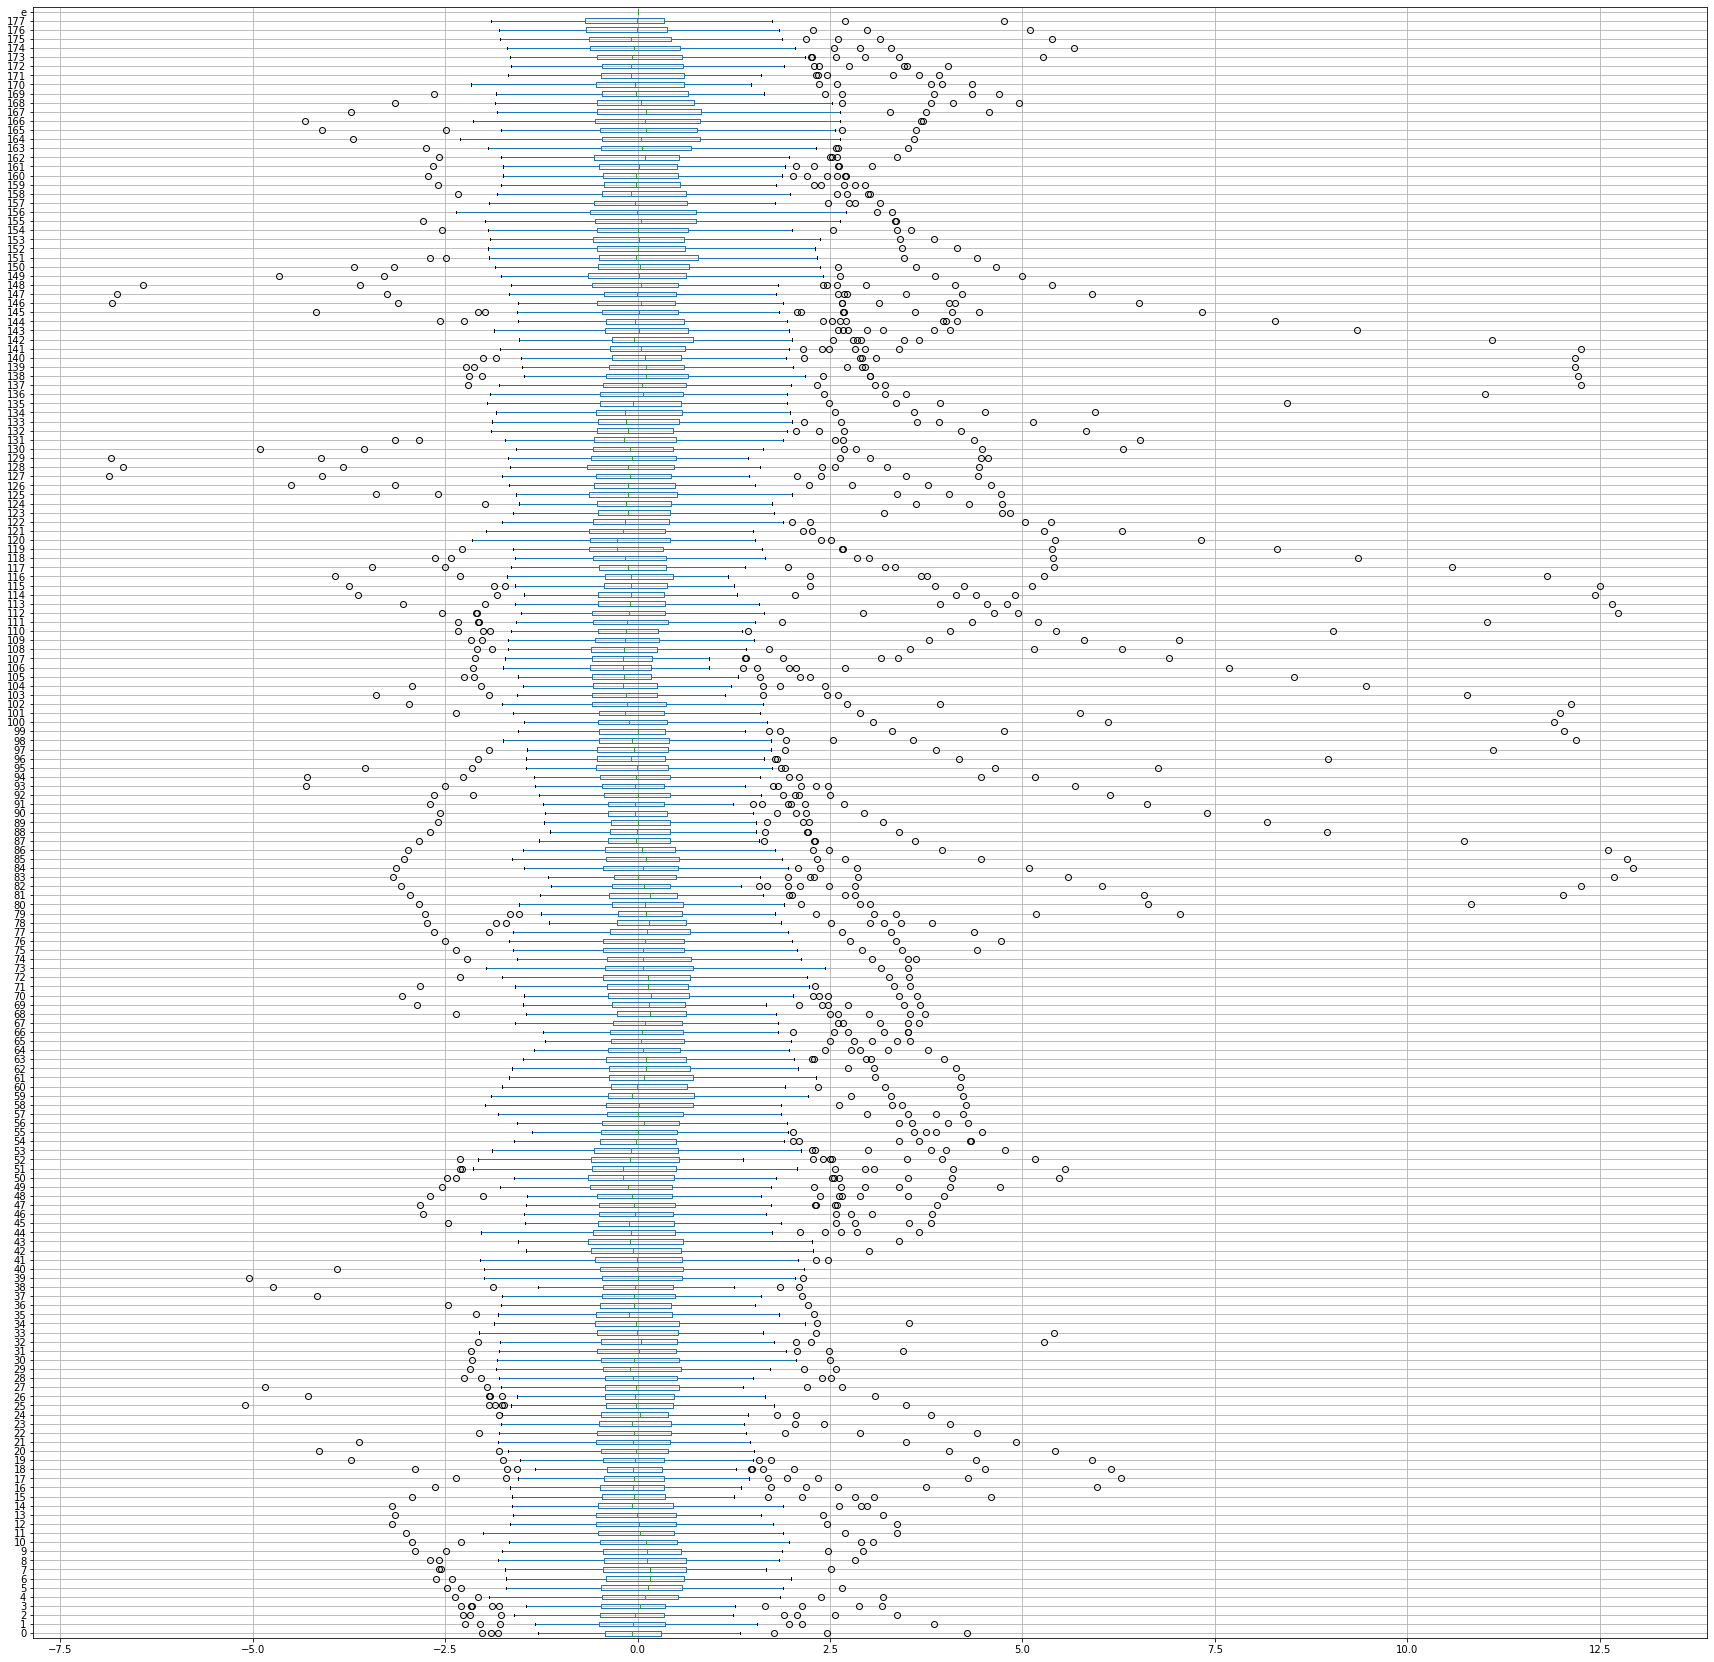

In [50]:
fp.boxplot(figsize = (30,30),vert=False)
plt.xlim(-7.85,13.90)
plt.show()